#### LSTM Model *does not* predict up/down movement well
* the decision to buy/sell is based on predicted gain/fall on a daily basis
* here, we evaluate the classification performance of the LSTM/RNN model

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
def lstm_train_and_test_eval(train_file, test_file):
    
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout
    from keras.layers import LSTM
    import math
    from sklearn.metrics import mean_squared_error
    
    # Importing the training set
    training_set = pd.read_csv(train_file)
    # input/ouputs of recurrent neural (input != date, stock price)
    # but stock price at time t for input, and stock price t+1 for the output
    # create a set only with the "Open" stock price, extract that column
    # two-dimensional numpy array
    training_set = training_set.iloc[:,1:2].values

    # Feature Scaling + Normalization, since LSTM Several Sigmoid Activation function
    # Sigmoid 0 and 1, as is the case in Normalization
    sc = MinMaxScaler(feature_range = (0,1))

    # Fitting to training_set, scale training set, 
    # transform we'll apply normalizationjust need min and max for normalization
    training_set_transform = sc.fit_transform(training_set)

    # Getting the inputs and the outputs, Y_train is output, X_train is the input
    # A special data structure is needed to cover 60-time stamps, based on which RNN
    # will predict the 61st price. Here the number of past timestamps is set to 60 based
    # on experimentation. Thus, X_train is a nested list, which contains lists of 60 time-stamp prices.
    # Y_train is a list of stock prices which is the next day stock price, corresponding to each list in X_train.
    X_train = []
    Y_train = []
    window = 60
        # "60" has nothing to do with number of days in the month
        # just the tried-and-tested window
    for i in range(window, len(training_set_transform)):
        X_train = np.append(X_train, training_set_transform[i-window: i, 0])
        Y_train = np.append(Y_train, training_set_transform[i, 0])
        X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Reshaping inputs, input has a certain format (2D array, features)
    # Changing the format of X_train into a 3D array, with a timestep
    # Keras Documentation - why reshape? - 3D tensor with shape (batch_size, timesteps)
    # time steps different between output and input time, input_dim dimension of input feature
    X_train = np.reshape(X_train, newshape = ((len(training_set)-window), window, 1))
    
    # Initialising the RNN
    # predicting a continuous outcome, regression model
    regressor = Sequential()

    # Then, add the 1st LSTM layer with the Dropout layer followed.
    NN_units = 50
        # number of units must be < window
    regressor.add(LSTM(units = NN_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(rate = 0.2))

    ##add 2nd lstm layer
    regressor.add(LSTM(units = NN_units, return_sequences = True))
    regressor.add(Dropout(rate = 0.2))

    ##add 3rd lstm layer
    regressor.add(LSTM(units = NN_units, return_sequences = True))
    regressor.add(Dropout(rate = 0.2))

    ##add 4th lstm layer
    regressor.add(LSTM(units = NN_units, return_sequences = False))
    regressor.add(Dropout(rate = 0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))
    
    # Compiling the RNN
    # use the mean square error
    # regression won't be binary cross entropy, MSE for regression
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Trainign set
    regressor.fit(x = X_train, y = Y_train, batch_size = 32, epochs = 200)
    
    #Visualize the result in training, because we have trained this on training data, this should match very closely

    X_train_predict = regressor.predict(X_train)
    X_train_predict = sc.inverse_transform(X_train_predict)

    # Visualising TRAINING results
    plt.rcParams['figure.dpi'] = 61
    plt.plot(training_set[window:len(training_set)], color = 'red', label = f'{train_file[10:13]} Actual Price')
    plt.plot(X_train_predict, color = 'blue', label = f'{train_file[10:13]} Predicted Price')
    plt.title(f'{train_file[10:13]} Prediction (training)')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    #Predict the data for August and sep 2022 using the data up to July 2022
    test_set = pd.read_csv(test_file)

    test_set = test_set.iloc[:,1:2].values
    test_set_transform = sc.fit_transform(test_set)

    Test_predict = []
    X_test = training_set_transform[len(training_set_transform)-window: len(training_set_transform), 0]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, newshape = (1, window, 1))

    T1_predict = regressor.predict(X_test)
    Test_predict = np.append(Test_predict, T1_predict)

    for i in range(len(test_set)-1):
        X_test = np.delete(X_test, 0)
        X_test = np.append(X_test, test_set_transform[i])
        X_test = np.reshape(X_test, newshape = (1, window, 1))

        T1_predict = regressor.predict(X_test)
        Test_predict = np.append(Test_predict, T1_predict)

    Test_predict = np.reshape(Test_predict, newshape = (len(test_set), 1))
    Test_predict = sc.inverse_transform(Test_predict)
    
    #Visualize the result in test 
    plt.rcParams['figure.dpi'] = 61
    plt.plot(test_set, color = 'red', label = f'Actual Aug-Sep 2022 {train_file[10:13]} Price')
    plt.plot(Test_predict, color = 'blue', label = f'Predicted Aug-Sep 2022 {train_file[10:13]} Price')
    plt.title(f'{train_file[10:13]} Price Prediction Aug-Sep 2022 (TEST)')
    plt.xlabel('Time')
    plt.ylabel('Time Price')
    plt.legend()
    plt.show()
    
    # evaluate performance
    test_set_list = [float(i) for i in test_set]
    Test_predict_list = [float(i) for i in Test_predict]
    test_difference = [item - test_set_list[idx - 1] for idx, item in enumerate(test_set_list)][1:]
    predict_difference = [item - Test_predict_list[idx - 1] for idx, item in enumerate(Test_predict_list)][1:]

    # test_difference, predict_difference
    predict_v_test = pd.DataFrame(
        {'predict_difference': predict_difference,
         'test_difference': test_difference
        })

    # replace values with 0 for <0 and 1 for >0
    # 0 indicate "to sell" and 1 indicate "to buy"
    df = predict_v_test
    df[df< 0 ] = 0 
    df[df> 0 ] = 1 

    from sklearn.metrics import accuracy_score, classification_report
    from sklearn.metrics import confusion_matrix, plot_confusion_matrix

    # Define the traget names
    target_names = ['Down Day', 'Up Day']

    # Build a classifcation report

    y_pred = df['predict_difference'].values.tolist()
    y_test = df['test_difference'].values.tolist()

    report = classification_report(y_true = y_test, 
                                   y_pred = y_pred, target_names = target_names, output_dict = True)

    # Add it to a data frame, transpose it for readability.
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(decimals=2)
    
    return report_df

#### test and eval on G3B

Metal device set to: Apple M2


2022-11-03 10:18:23.320168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-03 10:18:23.320270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2022-11-03 10:18:23.806440: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-03 10:18:25.078302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:18:25.294559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:18:25.409793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:18:25.500392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:18:25.591294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:18:25.725874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

3/3 [==============================] - 3s 382ms/step - loss: 0.2717
Epoch 2/200
3/3 [==============================] - 0s 54ms/step - loss: 0.1103
Epoch 3/200
3/3 [==============================] - 0s 57ms/step - loss: 0.0868
Epoch 4/200
3/3 [==============================] - 0s 54ms/step - loss: 0.0597
Epoch 5/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0583
Epoch 6/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0591
Epoch 7/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0446
Epoch 8/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0471
Epoch 9/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0508
Epoch 10/200
3/3 [==============================] - 0s 55ms/step - loss: 0.0388
Epoch 11/200
3/3 [==============================] - 0s 54ms/step - loss: 0.0398
Epoch 12/200
3/3 [==============================] - 0s 56ms/step - loss: 0.0380
Epoch 13/200
3/3 [==============================] - 0s 54ms/

3/3 [==============================] - 0s 59ms/step - loss: 0.0112
Epoch 104/200
3/3 [==============================] - 0s 61ms/step - loss: 0.0128
Epoch 105/200
3/3 [==============================] - 0s 55ms/step - loss: 0.0121
Epoch 106/200
3/3 [==============================] - 0s 61ms/step - loss: 0.0109
Epoch 107/200
3/3 [==============================] - 0s 59ms/step - loss: 0.0113
Epoch 108/200
3/3 [==============================] - 0s 56ms/step - loss: 0.0117
Epoch 109/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0116
Epoch 110/200
3/3 [==============================] - 0s 49ms/step - loss: 0.0109
Epoch 111/200
3/3 [==============================] - 0s 48ms/step - loss: 0.0112
Epoch 112/200
3/3 [==============================] - 0s 48ms/step - loss: 0.0108
Epoch 113/200
3/3 [==============================] - 0s 49ms/step - loss: 0.0108
Epoch 114/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0106
Epoch 115/200
3/3 [=======================

2022-11-03 10:19:00.011879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:00.090567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:00.180183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 1s

2022-11-03 10:19:00.271173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:00.360708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 148ms/step


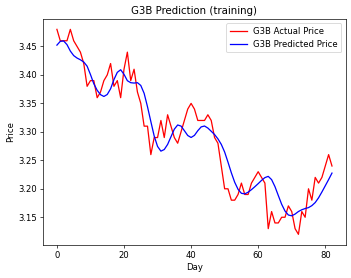

1/1 [==============================] - 0s 38ms/step


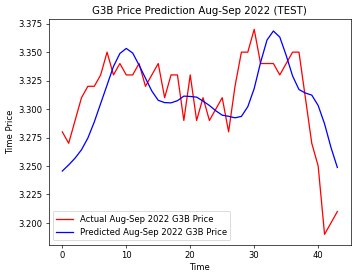

,precision,recall,f1-score,support
Down Day,0.48,0.55,0.51,22.00
Up Day,0.44,0.38,0.41,21.00
accuracy,0.47,0.47,0.47,0.47
macro avg,0.46,0.46,0.46,43.00
weighted avg,0.46,0.47,0.46,43.00


In [3]:
lstm_train_and_test_eval(train_file = 'data_lstm_G3B_train.csv',
                         test_file = './data_lstm_G3B_test.csv')

#### test and eval on S27

Epoch 1/200


2022-11-03 10:19:05.364113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:05.598800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:05.693978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:05.800302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:05.909280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:06.041125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:06.226728: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - 4s 436ms/step - loss: 0.1241
Epoch 2/200
3/3 [==============================] - 0s 73ms/step - loss: 0.0456
Epoch 3/200
3/3 [==============================] - 0s 71ms/step - loss: 0.0464
Epoch 4/200
3/3 [==============================] - 0s 71ms/step - loss: 0.0358
Epoch 5/200
3/3 [==============================] - 0s 74ms/step - loss: 0.0375
Epoch 6/200
3/3 [==============================] - 0s 66ms/step - loss: 0.0310
Epoch 7/200
3/3 [==============================] - 0s 63ms/step - loss: 0.0324
Epoch 8/200
3/3 [==============================] - 0s 68ms/step - loss: 0.0314
Epoch 9/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0270
Epoch 10/200
3/3 [==============================] - 0s 63ms/step - loss: 0.0294
Epoch 11/200
3/3 [==============================] - 0s 61ms/step - loss: 0.0275
Epoch 12/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0262
Epoch 13/200
3/3 [==============================] - 0s 61ms/

3/3 [==============================] - 0s 63ms/step - loss: 0.0073
Epoch 104/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0070
Epoch 105/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0074
Epoch 106/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0073
Epoch 107/200
3/3 [==============================] - 0s 63ms/step - loss: 0.0075
Epoch 108/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0079
Epoch 109/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0073
Epoch 110/200
3/3 [==============================] - 0s 64ms/step - loss: 0.0074
Epoch 111/200
3/3 [==============================] - 0s 63ms/step - loss: 0.0086
Epoch 112/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0075
Epoch 113/200
3/3 [==============================] - 0s 63ms/step - loss: 0.0103
Epoch 114/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0105
Epoch 115/200
3/3 [=======================

2022-11-03 10:19:46.047075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:46.134837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:46.239207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:46.343927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:46.447874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 175ms/step


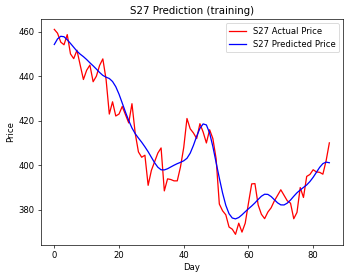

1/1 [==============================] - 0s 47ms/step


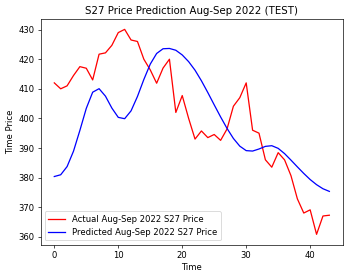

,precision,recall,f1-score,support
Down Day,0.42,0.50,0.46,22.0
Up Day,0.35,0.29,0.32,21.0
accuracy,0.40,0.40,0.40,0.4
macro avg,0.39,0.39,0.39,43.0
weighted avg,0.39,0.40,0.39,43.0


In [4]:
lstm_train_and_test_eval(train_file = 'data_lstm_S27_train.csv',
                         test_file = 'data_lstm_S27_test.csv')

#### test and eval on DBS

Epoch 1/200


2022-11-03 10:19:51.843855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:52.097685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:52.203007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:52.319099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:52.446150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:52.599894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:19:52.791447: I tensorflow/core/grappler/optimizers/cust

1/3 [=========>....................] - ETA: 6s - loss: 0.2614

2022-11-03 10:19:53.228328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 489ms/step - loss: 0.1701
Epoch 2/200
3/3 [==============================] - 0s 95ms/step - loss: 0.0583
Epoch 3/200
3/3 [==============================] - 0s 89ms/step - loss: 0.0609
Epoch 4/200
3/3 [==============================] - 0s 78ms/step - loss: 0.0452
Epoch 5/200
3/3 [==============================] - 0s 73ms/step - loss: 0.0441
Epoch 6/200
3/3 [==============================] - 0s 83ms/step - loss: 0.0407
Epoch 7/200
3/3 [==============================] - 0s 68ms/step - loss: 0.0368
Epoch 8/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0373
Epoch 9/200
3/3 [==============================] - 0s 80ms/step - loss: 0.0341
Epoch 10/200
3/3 [==============================] - 0s 73ms/step - loss: 0.0307
Epoch 11/200
3/3 [==============================] - 0s 67ms/step - loss: 0.0328
Epoch 12/200
3/3 [==============================] - 0s 70ms/step - loss: 0.0270
Epoch 13/200
3/3 [==============================] - 0s 68ms/

3/3 [==============================] - 0s 75ms/step - loss: 0.0030
Epoch 104/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0027
Epoch 105/200
3/3 [==============================] - 0s 75ms/step - loss: 0.0029
Epoch 106/200
3/3 [==============================] - 0s 77ms/step - loss: 0.0026
Epoch 107/200
3/3 [==============================] - 0s 77ms/step - loss: 0.0031
Epoch 108/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0029
Epoch 109/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0027
Epoch 110/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0031
Epoch 111/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0031
Epoch 112/200
3/3 [==============================] - 0s 79ms/step - loss: 0.0032
Epoch 113/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0034
Epoch 114/200
3/3 [==============================] - 0s 76ms/step - loss: 0.0030
Epoch 115/200
3/3 [=======================

2022-11-03 10:20:41.940551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:20:42.063614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:20:42.202201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 10:20:42.345847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 3s

2022-11-03 10:20:42.512825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 252ms/step


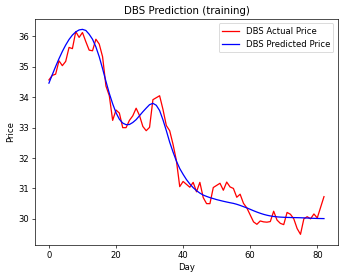

1/1 [==============================] - 0s 59ms/step


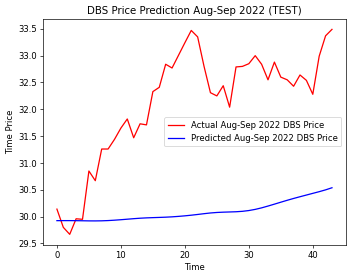

,precision,recall,f1-score,support
Down Day,0.50,0.10,0.17,20.00
Up Day,0.54,0.91,0.68,23.00
accuracy,0.53,0.53,0.53,0.53
macro avg,0.52,0.51,0.42,43.00
weighted avg,0.52,0.53,0.44,43.00


In [5]:
lstm_train_and_test_eval(train_file = 'data_lstm_DBS_train.csv',
                         test_file = 'data_lstm_DBS_test.csv')